In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from time import sleep
from random import randint

from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [3]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 

In [4]:
## load data
indir_list = ['music/audio features_miri/', 'Data/audio_features2/', 'zoe/features/aaron_oh_experience/',
'zoe/features/party_songs/', 'zoe/features/playlists/', 'zoe/features/ultimate_party_mix/']

required_cols = ['id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

infile_list = []
for indir in indir_list:
    infile_list += [f"{indir}{x}" for x in os.listdir(indir)]

dfs = []
for fname in infile_list:
    if fname.endswith(".csv"):
        tempdf = pd.read_csv(fname, index_col=None)
        dfs.append(tempdf[required_cols].drop_duplicates().reset_index(drop=True))
    
df = pd.concat(dfs, axis=0)
df = df.drop_duplicates().reset_index(drop=True)


### checking on the file system

```
## get info for values in columns:
## danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id

(da-ironhack) nina@Ninas-Air Song_Recommodation_Project % 

grep -C 1 6ZahQeSE8fqyvC0jKr7CHA Data/audio_features2/*.csv | cut -d, -f1-11,13 | cut -f 2- -d-

0.709,0.803,3,-5.862,0,0.0323,0.101,0.919,0.192,0.356,124.0,6j9smjwHuQRmb41odOHS8Q
6.678,1,0.045,0.0272,0.913,0.117,0.0296,123.978,6ZahQeSE8fqyvC0jKr7CHA
0.561,0.63,1,-8.019,0,0.0344,0.108,0.178,0.134,0.0378,121.998,6n7bXOBucoX8BOQ8kFopov

grep -C 1 6ZahQeSE8fqyvC0jKr7CHA zoe/features/*/*.csv | cut -d, -f1-11,13 | cut -f 2- -d-

0.528,0.608,2,-7.071,0,0.0283,0.0364,0.0194,0.112,0.0946,144.973,0mWXMQ8hrrAJfxN7LG2Wsk
6.672,1,0.0428,0.0185,0.926,0.115,0.0305,124.004,6ZahQeSE8fqyvC0jKr7CHA
0.741,0.902,6,-4.695,0,0.0551,0.0633,0.337,0.143,0.743,125.004,4UV5qm4XHQETdXrVZjIsSU

```
weird... I dunno, why would we get two slightly different records for the same id?


In [141]:
df.shape

(51524, 14)

In [135]:
df[df.isnull().any(axis=1)].shape

(0, 14)

In [136]:
df[df.id.duplicated()]

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
45022,6ZahQeSE8fqyvC0jKr7CHA,0.52,0.962,7,-6.672,1,0.0428,0.0185,0.926,0.115,0.0305,124.004,315861,4


In [142]:
df[df.id == '6ZahQeSE8fqyvC0jKr7CHA']

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
27319,6ZahQeSE8fqyvC0jKr7CHA,0.502,0.959,7,-6.678,1,0.0450,0.0272,0.913,0.117,0.0296,123.978,315877,4
45022,6ZahQeSE8fqyvC0jKr7CHA,0.520,0.962,7,-6.672,1,0.0428,0.0185,0.926,0.115,0.0305,124.004,315861,4


### FIX: ensure id values are unique (just drop one of the dups)

In [5]:
df = df.drop_duplicates('id').reset_index(drop=True)

### But wait, there's still more duplication... keep unique features only

ie drop records that differ by id only

In [6]:
df = df[~df[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']].duplicated()].reset_index(drop=True)

In [7]:
df.shape

(51022, 14)

## Run 2 : dropping features

Try removing: 
* duration_ms -- the small cluster is the very long songs. feature is uninformative
* time_signature -- not sure if this value is always entered correctly... what does 1 mean? generally uninformative
* mode, key -- a cluster based on these features doesn't make sense


In [85]:
## Round 2: drop 4 features
df2 = df.drop(['key', 'mode', 'duration_ms', 'time_signature', 'k16_cluster',
       'pp2_k12_cluster'], axis=1).reset_index(drop=True)
X = df2.drop('id', axis=1).reset_index(drop=True)

In [86]:
df2.columns

Index(['id', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [84]:
df.columns

Index(['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'k16_cluster',
       'pp2_k12_cluster'],
      dtype='object')

## Prepare X

In [80]:
## drop id and keep the rest
X = df.drop('id', axis=1).reset_index(drop=True)

In [164]:
## confirm no null values
X[X.isnull().any(axis=1)].shape

(0, 13)

In [166]:
## confirm no duplicates
X[X.duplicated()].shape

(0, 13)

In [87]:
## normalize
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

In [88]:
scaler_filename =  "Model/postpresentation2-big-scaler.pickle"
with open(scaler_filename, "wb") as f:
    pickle.dump(scaler,f)
print(f'Saved StandardScaler model as: {scaler_filename}')

Saved StandardScaler model as: Model/postpresentation2-big-scaler.pickle


In [89]:
K = range(2, 20)
silhouette = []
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1337)
    kmeans.fit(X_scaled_df)
    
    filename = f"Model/postpresentation2_big_kmeans_{k}.pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


### Plots: round 2

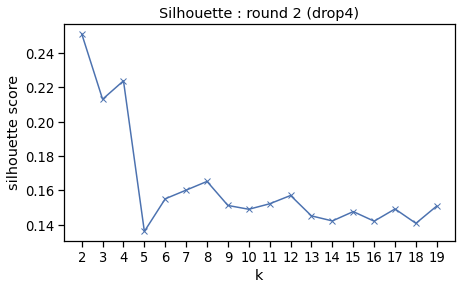

In [35]:
### ---- plot silhouette : round 2 ------
plt.figure(figsize=(7,4))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette : round 2 (drop4)')
plt.show()

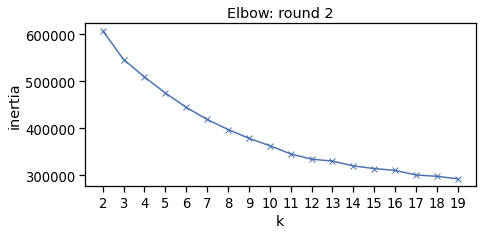

In [36]:
plt.figure(figsize=(7,3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow: round 2')
plt.show()

### Plots: all features

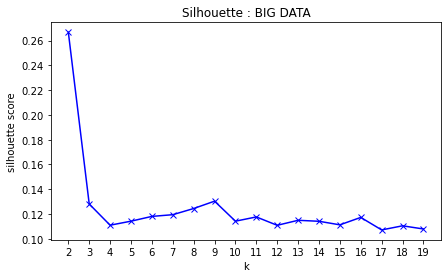

In [12]:
### ---- plot silhouette  ------
plt.figure(figsize=(7,4))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette : BIG DATA')
plt.show()

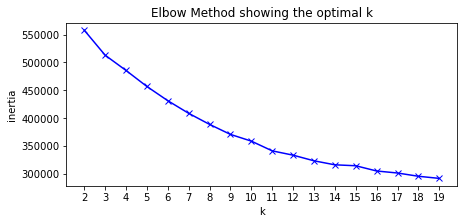

In [13]:
plt.figure(figsize=(7,3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')
plt.show()

In [78]:
df2 = df2.drop(['pp2_k12_cluster', 'pp2_k15_cluster'], axis=1).reset_index(drop=True)

# Round 2: Extract cluster label assignment for k=12 & k=15

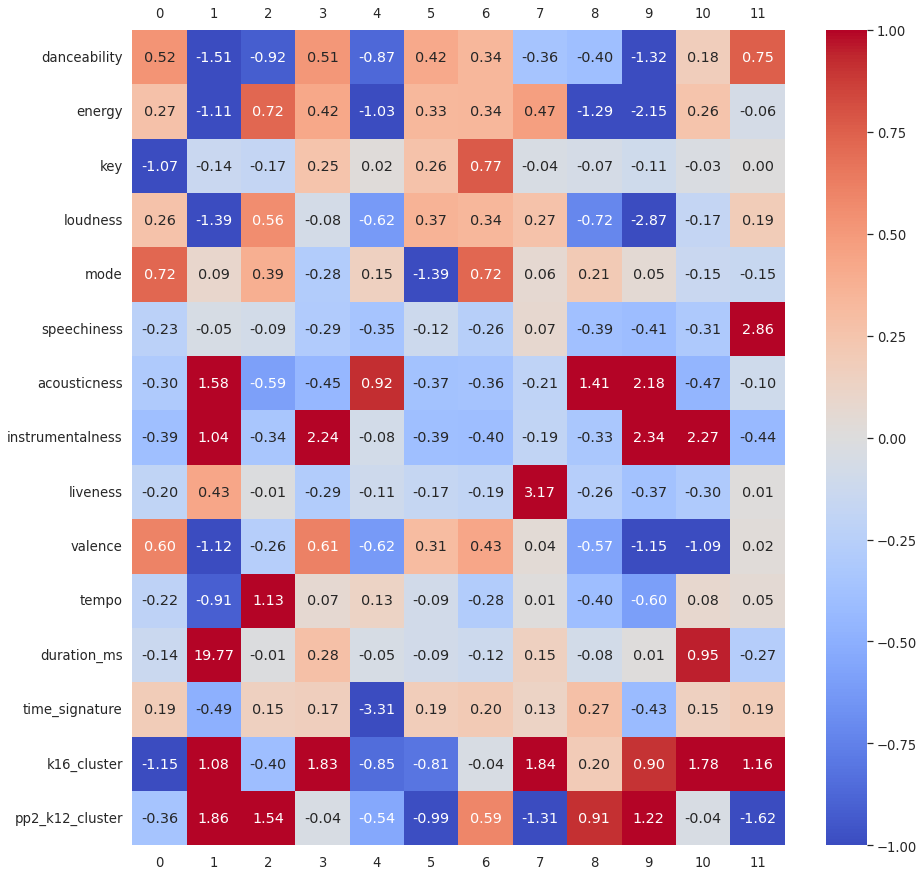

In [53]:
df2, scaled_feature_means_by_cluster, cluster_members = assess_k_cluster_assignments(12, 
                                            df2, X_scaled_df, 'postpresentation2', 'pp2')

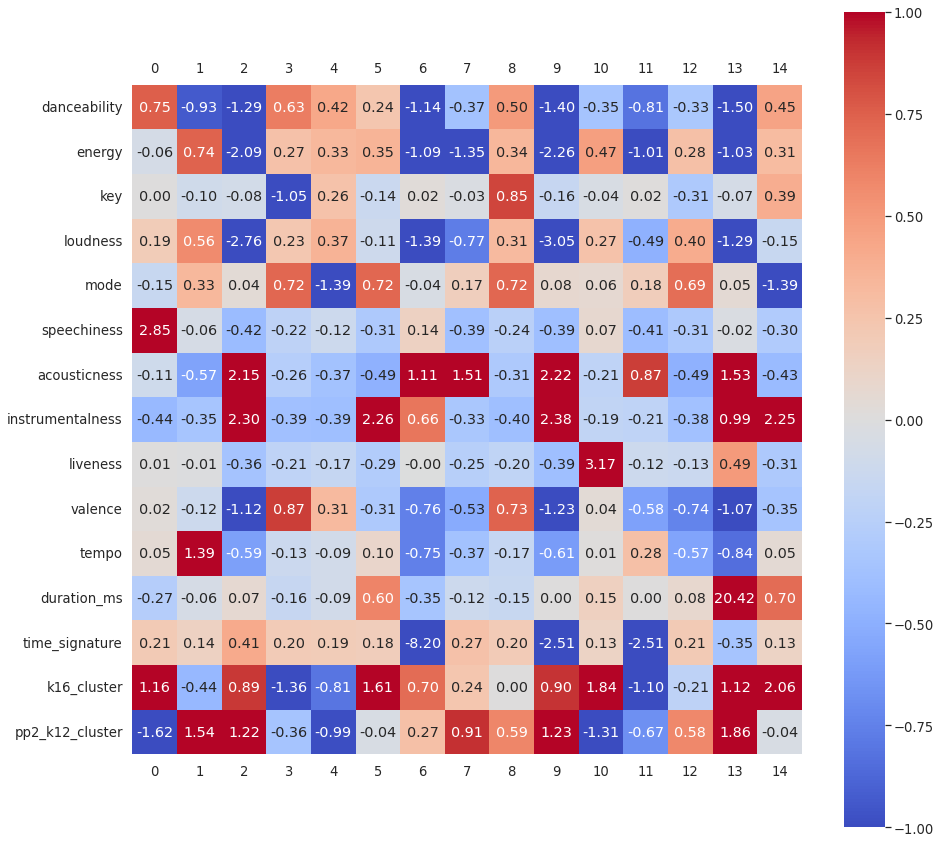

In [49]:
df2, scaled_feature_means_by_cluster, cluster_members = assess_k_cluster_assignments(15, 
                                            df2, X_scaled_df, 'postpresentation2', 'pp2')

In [51]:
df2.pp2_k12_cluster.value_counts()

5     9445
6     7765
0     6604
2     6415
8     5392
11    3595
7     2588
10    2451
9     2391
4     2349
3     1980
1       47
Name: pp2_k12_cluster, dtype: int64

In [52]:
df2.pp2_k15_cluster.value_counts()

4     9420
8     6048
3     5401
1     5376
7     4914
12    4418
0     3589
10    2591
5     2472
11    2041
14    1938
2     1755
9      679
6      336
13      44
Name: pp2_k15_cluster, dtype: int64

# Round 1: Extract cluster label assignment for k=16

In [40]:
def assess_k_cluster_assignments(kval, df, X_scaled_df, modelname, clustersetname):
    ## load the trained model with the k == kval
    kmeans = load(f"Model/{modelname}_big_kmeans_{kval}.pickle")

    cluster_run_name = f'{clustersetname}_k{kval}_cluster'
    # create new col in main df with the cluster label the model assigned to each track
    df[cluster_run_name] = kmeans.labels_

    ## create dictionary of cluster membership for each label
    cluster_labels = np.unique(df[cluster_run_name])
    cluster_members = {}
    for cluster in cluster_labels:
        cluster_members[cluster] = np.where(df[cluster_run_name] == cluster)

    ## for each cluster label (ky) calculate the mean for each feature
    scaled_feature_means_by_cluster = pd.DataFrame([X_scaled_df.loc[cluster_members[ky]].mean(numeric_only=True) for ky in cluster_members.keys()])

    ## --- plot results as heatmap
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 15))
        sns.set(font_scale=1.2) 
        ax = sns.heatmap(scaled_feature_means_by_cluster.T, fmt='.2f', cmap='coolwarm', 
                         vmin=-1, vmax=1, annot=True, square=True)
        plt.tick_params(labelbottom = True, labeltop = True)
        
    return df, scaled_feature_means_by_cluster, cluster_members
    

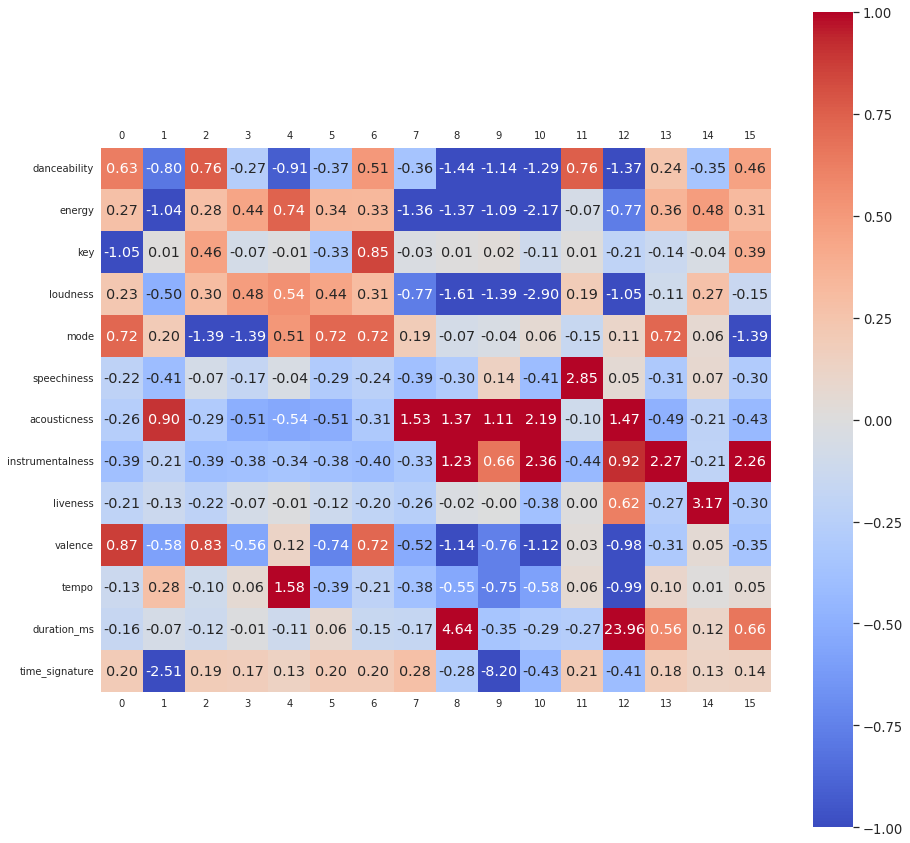

In [18]:
df, scaled_feature_means_by_cluster, cluster_members = assess_k_cluster_assignments(16, df, X_scaled_df)

In [19]:
df.k16_cluster.value_counts()

6     5990
2     5697
0     5391
5     5012
7     4830
3     4414
4     4233
11    3580
14    2557
13    2470
10    2221
1     1973
15    1927
8      360
9      336
12      31
Name: k16_cluster, dtype: int64

## Hierarchical clustering of the clusters

In [ ]:
## experiment...



## Save feature means to .csv

In [54]:
## Note: row index is cluster label, so include it in output
scaled_feature_means_by_cluster.to_csv('Model/postpresentation2_k12_scaled_feature_means_by_cluster.csv')

In [55]:
feature_means_by_cluster = pd.DataFrame([df2.loc[cluster_members[ky]].mean(numeric_only=True) for ky in cluster_members.keys()])

In [58]:
feature_means_by_cluster = feature_means_by_cluster.drop(columns=['pp2_k12_cluster', 'pp2_k15_cluster']).reset_index(drop=True)

In [60]:
feature_means_by_cluster.to_csv('Model/postpresentation2_k12_UNscaled_feature_means_by_cluster.csv')

In [59]:
feature_means_by_cluster

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.673419,0.704243,-7.261355,0.064163,0.160488,0.024110,0.162376,0.658885,115.410711
1,0.324585,0.373523,-15.457191,0.081526,0.738721,0.438327,0.267666,0.227287,95.693936
2,0.425562,0.813658,-5.785438,0.077855,0.073499,0.040202,0.194006,0.442871,153.526234
3,0.670972,0.741334,-8.952902,0.058332,0.116265,0.786141,0.147715,0.661863,123.377267
4,0.433964,0.391699,-11.648635,0.052405,0.535005,0.113704,0.176692,0.352714,125.188821
5,0.655451,0.718916,-6.762036,0.074604,0.140250,0.024455,0.167524,0.585597,118.979782
6,0.642229,0.720950,-6.878394,0.061615,0.142519,0.022168,0.164041,0.616500,113.503603
7,0.522448,0.752985,-7.260421,0.092976,0.189839,0.082171,0.723743,0.518792,121.775140
8,0.515613,0.328744,-12.159846,0.049034,0.686046,0.043172,0.152076,0.364238,110.162359
9,0.356726,0.122154,-22.801409,0.047498,0.923340,0.815141,0.133623,0.218569,104.581630


# Save id and cluster assignments to .csv

In [61]:
## create smaller df with just the id and the cluster labels
id_and_labels_df = df2[['id', 'pp2_k12_cluster']]
id_and_labels_df.shape

(51022, 2)

In [62]:
## check for null values -- nothing -- good
id_and_labels_df[id_and_labels_df.isnull().any(axis=1)]

,id,pp2_k12_cluster


In [63]:
## check for duplicated values -- nothing -- good
id_and_labels_df[id_and_labels_df.duplicated()]

,id,pp2_k12_cluster


In [22]:
id_and_labels_df.to_csv('Data/cluster_labels/postpresentation2_big_data_id_and_cluster_labels.csv', index=False)

## Add artist name and track title 

In [23]:
df.columns

Index(['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'k16_cluster'],
      dtype='object')

# Pasting together the artist-title-id info with the cluster labels

In [64]:
## load files with track artist and title data
cluster_labels_col = 'pp2_k12_cluster'
indir = 'Data/artist_title_id/'
outdir = 'Data/db'

infile_list = os.listdir(indir)

dfs = []

all_ids_list = []
for fname in infile_list:
    if fname.endswith('.csv'):
        ## Load df with track artist and title
        fname_df = pd.read_csv(os.path.join(indir, fname), index_col=None)
                
        ## check for and handle NULL values
        fname_nulls = fname_df[fname_df.isnull().any(axis=1)]

        if fname_nulls.shape[0] > 0:
            #drop the null records and continue
            print(f'Dropping {fname_nulls.shape[0]} null records')
            fname_df = fname_df[~fname_df.isnull().any(axis=1)].reset_index(drop=True)

        ## deduplicate
        fname_df = fname_df.drop_duplicates().reset_index(drop=True)
        
        ## drop artist and track info for ids not in id_and_labels
        fname_df = fname_df[fname_df['id'].isin(id_and_labels_df.id.to_list())].reset_index(drop=True)
        
        ## load label and id info        
        my_info = id_and_labels_df[id_and_labels_df['id'].isin(fname_df.id.to_list())].reset_index(drop=True)
        all_ids_list += fname_df.id.to_list()
        
        fname_df[cluster_labels_col] = fname_df.id.map(my_info.set_index('id')[cluster_labels_col])
        
        null_cluster_label = fname_df[fname_df[cluster_labels_col].isnull()]

        if null_cluster_label.shape[0] > 0:
            print(f"ERROR!! Null values in cluster assignment!")
            
        else:
            outfilename = os.path.join(outdir, "postpresentation2_"+fname.split('.')[0].split('_')[0]+".csv")
            fname_df.to_csv(outfilename, index=False)
            print(f'Saved new DB file ({fname_df.shape[0]}): {outfilename}')

missing_track_info = id_and_labels_df[~id_and_labels_df['id'].isin(all_ids_list)].reset_index(drop=True)
missing_track_info.shape

Saved new DB file (14924): Data/db/postpresentation2_batchA2.csv
Dropping 1 null records
Saved new DB file (4996): Data/db/postpresentation2_batchA1.csv
Saved new DB file (15588): Data/db/postpresentation2_batchB.csv
Dropping 3 null records
Saved new DB file (15511): Data/db/postpresentation2_batchC.csv


(4, 2)

In [198]:
missing_track_info

,id,k9_cluster
0,2qK37pJlCIgZ7uv4kheUXQ,6
1,7EQoRKZQ1Y792aF7B6nPS6,7
2,69gRFGOWY9OMpFJgFol1u0,3
3,6UA1pZet2JQSrvBGWx1F05,5


ok...we can live without those 4 tracks... move on to use these db files in the main loop